### Notebook Purpose

Perform quant and qual evaluation for fastmri results in ismrm paper

Note: code used to create ismrm output, i.e. model6 below, are in `~/old_convdecoder_pt1.5_20201218/`. need to first activate virtualenv `old_pt_heck`

### starting points to merge codebases w/o performance discrepancy
- potential issues across pt versions
    - fft/ifft work differently
    - low-level detail w torch, torchvision, etc
        - recall: csdip worked much worse on a newer version of pytorch
        - but also it works well on qdess, so must be dataset-specific
- see results below for ssim/psnr values over n=5 samples
- potential solutions
    - retrofit current method (pt==1.7) and to work with old fft/ifft while using pt==1.7
        - first test to see whether there's a difference b/w running...
            - new fft/ifft in pt==1.7
            - old fft/ifft in pt==1.7
            - old fft/ifft in pt==1.5
        - if no difference, then maybe don't retrofit
    - start with old method (in `old` branch/venv running pt==1.5)
        - run qdess w this and see if qdess results are same as pt==1.7
        - if so, apply new data processing / functions built when originally converted pt==1.5-->1.7, but keep the fft/ifft functions as old because need to use pt==1.5

In [46]:
import os, sys
from os import listdir
from os.path import isfile, join
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
import matplotlib.gridspec as gridspec

sys.path.append('/home/vanveen/ConvDecoder/')
from utils.data_io import load_h5
from utils.evaluate import calc_metrics, norm_imgs
from utils.transform import fft_2d, ifft_2d, root_sum_squares, \
                            reshape_complex_vals_to_adj_channels, \
                            reshape_adj_channels_to_complex_vals, \
                            crop_center

In [7]:
def load_gt(file_id, slice_idx=None):
    _, ksp_orig = load_h5(file_id, slice_idx=slice_idx)
    ksp_orig = torch.from_numpy(ksp_orig)
    return crop_center(root_sum_squares(ifft_2d(ksp_orig)), DIM, DIM)

def load_fastmri_baseline(file_id, path_bl, slice_idx=None):
    ''' given file_id e.g. 1000818, load from pre-defined directory '''
    
    arr = torch.from_numpy(np.load('{}file{}.npy'.format(path_bl, file_id)))
    
    # get central slice
    if not slice_idx:
        slice_idx = arr.shape[0] // 2
    arr = arr[slice_idx, :, :, :, :]
    
    # combine real/complex values
    arr_new = torch.empty((arr.shape[0], arr.shape[1]), dtype=torch.complex64)
    arr_new.real = arr[:, :, 0, 0]
    arr_new.imag = arr[:, :, 0, 1]
    
    return np.array(torch.absolute(arr_new))  

def plot_list(arr_list, clim=(0, .1)):
    
    NUM_COLS = len(arr_list)
    title_list = ['ground-truth', 'dd+', 'u-net']
    
    fig = plt.figure(figsize=(20,20))
    
    for idx in range(NUM_COLS):
        ax = fig.add_subplot(1,NUM_COLS,idx+1)
        ax.imshow(arr_list[idx], cmap='gray', clim=clim)
        ax.set_title(title_list[idx], fontsize=20)
        ax.axis('off')

### compare old dd+ (pytorch==1.5) vs new dd+ (pytorch==1.7)

from the baseline directory `/bmrNAS/people/dvv/out_fastmri/`...
- (1) `old_pytorch1.5/orig_alpha_search/` (n=11): using dd+ pt==1.5 before code re-work 
- (2) `old_pytorch1.5/sf0.1/` (n=5): using dd+ pt==1.5 after code re-work, then converted back
    - not sure if this is actually in pt==1.5 or if i just took pt==1.7 and used the deprecated fft/ifft functions in a hacky way. either way, i might have this stashed in a branch somewhere?
- (3) `new_pytorch1.7/sf0.1/` (n=5): using dd+ pt==1.7 sf0.1 w `fit.py`
- (4) `expmt_fm_loss/trials_best/` (n=11): using dd+ pt==1.7 sf=0.1 w `fit_feat_map_loss.py` instead of `fit.py`
    - i.e. looking at trial_id = `0000_10k`

##### results
- 1 > 4
- 2 > 1, but we only have five samples for 2
- 2, 3 are comparable
- ssim, psnr
    - (1)
        - n=5: 0.7884340675904544 31.730754973365197
        - n=11: 0.7569765714478369 30.87466793360071
    - (2) 0.796467652242989 32.034361010080524
    - (3) 0.793504546953909 31.93507930075753
    - (4)
        - n=5: 0.7647340218936469 30.56831878262691
        - n=11: 0.7399233683613828 29.98914482917978

# TODO
- currently running over test samples in `ismrm/model6/`
    - evaluate output over entire set for final quant results
- run over some samples from annotated samples in csv per akshay
    - try file1000538 at particular slices 
    - determine qual samples for display
- run fm_reg in old env

### model list
- `ismrm/model5/`: run current processing (pt==1.7, recent code) w scale_factor=0.1 using `fit.py`. if this yields decent results, will indicate that there is some discrepancy when alpha_fm=0 calling `fit_feat_map.py`
    - got ssim .7694 across n=5 --> too low
- `ismrm/model6/`: run old processing (pt==1.5, code pulled from git branch old_code_mod_for_pt1.7 + converted back to old fft/ifft)
    - got ssim .7885 across n=5 --> will work for paper
    - how to re-create this? use python venv `old_pt_heck` and run `python_run_expmt_test_old_v_new.py`
    - TODO: merge this with current processing...

In [3]:
path_base = '/bmrNAS/people/dvv/out_fastmri/'
path_2 = path_base + 'compare_pt_versions/old_pytorch1.5/sf0.1/'
path_3 = path_base + 'compare_pt_versions/new_pytorch1.7/sf0.1/'
path_4 = path_base + 'expmt_fm_loss/'
path_6 = path_base + 'ismrm/model6/'

In [35]:
ACCEL = 4

path_bl_1 = '/bmrNAS/people/arjun/results/ss_recon/fastMRI_knee_mc/baseline_{}x_dev/20_percent/test_results/fastMRI_knee_multicoil_v0.0.1_test/'.format(ACCEL)
path_bl_2 = '/bmrNAS/people/arjun/results/ss_recon/fastMRI_knee_mc/baseline_{}x_dev/full/test_results/fastMRI_knee_multicoil_v0.0.1_test/'.format(ACCEL)
path_bl = path_bl_2
    
path_recons = path_6 + 'accel_{}x/'.format(ACCEL)

# n = 5 or n = 11 prototyping test set
# file_id_list = ['1000273', '1000325', '1000464', \
#                 '1000537', '1000818', '1001140', '1001219', \
#                 '1001338', '1001598', '1001533', '1001798']
# file_id_list = ['1000273', '1000325', '1000464', '1000537', '1000818']

# full test set
file_id_list = list(set([f.split('_')[0] for f in listdir(path_recons) if isfile(join(path_recons, f))]))
file_id_list.sort()

In [5]:
DIM = 320
NUM_SAMPS = len(file_id_list)
NUM_VARS = 3 # ground-truth, our output, original baseline
NUM_METRICS = 4 # vif, msssim, ssim, psnr

im_list = np.empty((NUM_SAMPS, NUM_VARS, DIM, DIM))
metric_dc_list = np.empty((NUM_SAMPS, NUM_METRICS))
metric_bl_list = np.empty((NUM_SAMPS, NUM_METRICS))

sys.exit()

for idx, file_id in enumerate(file_id_list):
    
    img_gt = np.array(load_gt(file_id))
    img_bl = load_fastmri_baseline(file_id, path_bl)
    
    img_dc = np.load('{}{}_dc.npy'.format(path_recons, file_id)).astype('float32')
#     img_dc = np.load('{}{}_iter10000_alpha0.npy'.format(path_1, file_id))
#     img_dc = np.load('{}0000_10k_{}_dc.npy'.format(path_4, file_id))   

    img_gt, img_dc = norm_imgs(img_gt, img_dc)
    img_gt, img_bl = norm_imgs(img_gt, img_bl)
        
    metric_dc_list[idx] = calc_metrics(img_gt, img_dc, imgs_already_normed=True)
    metric_bl_list[idx] = calc_metrics(img_gt, img_bl, imgs_already_normed=True)
    
    im_list[idx] = [img_gt, img_dc, img_bl]

#     img_diff = np.abs(img_dc - img_gt)

print('dd+')
print(np.mean(metric_dc_list, axis=0))
print(np.std(metric_dc_list, axis=0))

print('\nu-net')
print(np.mean(metric_bl_list, axis=0))
print(np.std(metric_bl_list, axis=0))

SystemExit: 

/home/vanveen/heck/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3425: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


##### metrics computed over 73/101 samples in val set

##### results as of 20201209, 4x

dd+
[ 0.68402424  0.94416455  0.76882118 31.54299076]
[0.12627246 0.02239209 0.08731028 1.93203486]

u-net, expmt 1
[ 0.70964022  0.92548806  0.76399353 30.65031426]

u-net, expmt 2
[ 0.69305595  0.92876906  0.76443703 30.69887474]
[0.12917964 0.03640427 0.09809617 2.11912296]

##### results as of 20201212, 8x
dd+
[ 0.56021184  0.9111758   0.68543246 28.9667684 ]
[0.13513955 0.02661574 0.091158   1.75863089]

u-net, expmt 1
[ 0.47419086  0.88168009  0.65006477 27.7466918 ]

u-net, expmt 2
[ 0.45876708  0.87629119  0.6436515  27.68215261]
[0.11833104 0.03627294 0.09304085 1.75465451]

### look at specific pathology from `file_id=1000538`

In [36]:
slice_idx_list = [29, 30, 31, 32]
NUM_SAMPS = len(slice_idx_list)

im_list = np.empty((NUM_SAMPS, NUM_VARS, DIM, DIM))
metric_dc_list = np.empty((NUM_SAMPS, NUM_METRICS))
metric_bl_list = np.empty((NUM_SAMPS, NUM_METRICS))

file_id = '1000538'

path_ss = path_recons + 'specific_slices/'

for idx, slice_idx in enumerate(slice_idx_list):
    
    img_gt = np.array(load_gt(file_id, slice_idx))
    img_bl = load_fastmri_baseline(file_id, path_bl, slice_idx)
    
    img_dc = np.load('{}{}_slice{}_dc.npy'.format(path_ss, file_id, slice_idx)).astype('float32')
#     img_dc = np.load('{}{}_iter10000_alpha0.npy'.format(path_1, file_id))
#     img_dc = np.load('{}0000_10k_{}_dc.npy'.format(path_4, file_id))   

    img_gt, img_dc = norm_imgs(img_gt, img_dc)
    img_gt, img_bl = norm_imgs(img_gt, img_bl)
        
    metric_dc_list[idx] = calc_metrics(img_gt, img_dc, imgs_already_normed=True)
    metric_bl_list[idx] = calc_metrics(img_gt, img_bl, imgs_already_normed=True)
    
    im_list[idx] = [np.flip(img_gt, 0), np.flip(img_dc, 0), np.flip(img_bl, 0)]

### get metrics for specific slice

In [38]:
metric_dc_list[IDX_OI], metric_bl_list[IDX_OI]

(array([ 0.61733062,  0.9407025 ,  0.78610762, 32.17499136]),
 array([ 0.63175396,  0.93000031,  0.79677017, 31.63363108]))

4x accel

(array([ 0.61733062,  0.9407025 ,  0.78610762, 32.17499136]),
 array([ 0.63175396,  0.93000031,  0.79677017, 31.63363108]))


8x accel

(array([ 0.481394  ,  0.91303295,  0.67279751, 30.25927732]),
 array([ 0.40027855,  0.87864518,  0.63311953, 29.17970046]))

### crop, plot image

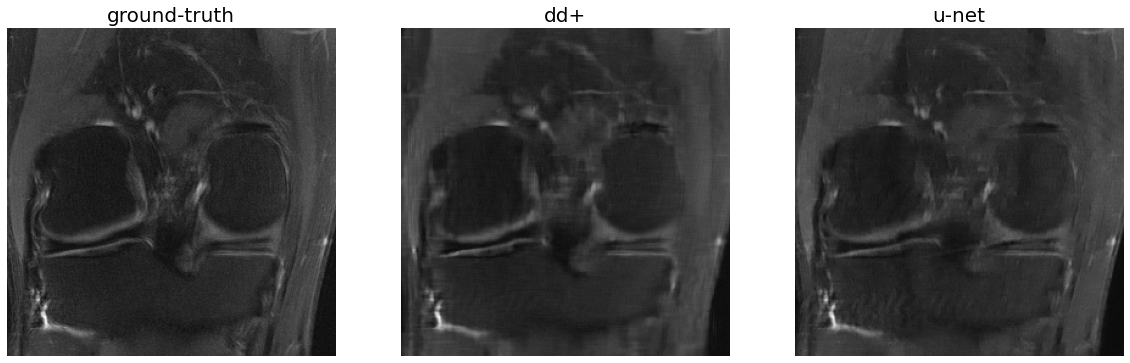

In [39]:
IDX_OI = 1 # corresponds to slice 30
im_list_oi = im_list[IDX_OI]

im_list_oi_ = []

for idx, im in enumerate(im_list_oi):
    im_list_oi_.append(im[40:310,30:300])
    
plot_list(np.array(im_list_oi_))

In [41]:
# im_list_oi_4 = im_list_oi_
# im_list_oi_8 = im_list_oi_

im_list_4_8 = np.array([im_list_oi_4, im_list_oi_8])

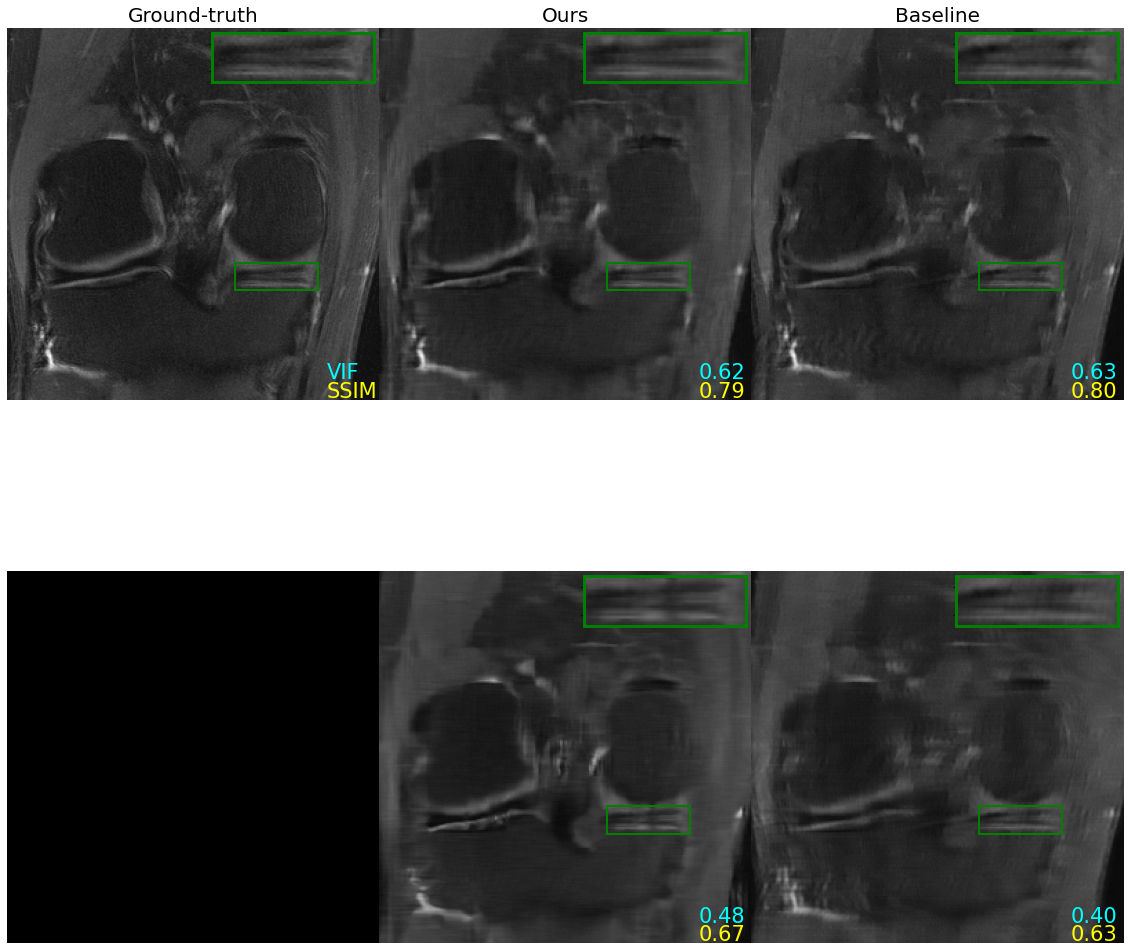

In [121]:
# idx_row, idx_col
dict_scores = {'0': {'0': ('VIF', 'SSIM'), '1': ('0.62', '0.79'), '2': ('0.63', '0.80')},
               '1': {'0': ('', ''), '1': ('0.48', '0.67'), '2': ('0.40', '0.63')}}

dict_inset_bbox = {'1000538': {'bbox': (165, 170, 60, 20),
                              'inset': (156, 76, 59, 18)}}

plot_list_many_rows(im_list_4_8, bbox=True, inset=True)

# temp = np.array([[im_list_4_8[0][0]]])
# plot_list_many_rows(temp, bbox=True, inset=True)

### plot baby

In [120]:
def plot_list_many_rows(arr_list, clim=(0,.1), bbox=False, display_scores=True, inset=False):
    ''' given list of arrays arr_list, plot 
        dimns of arr_list (rows, cols, x, y) 
                 e.g. (3,4,x,y) would plot 3 rows of 4 cols '''
    
    assert arr_list.ndim == 4
    
    NUM_ROWS, NUM_COLS = arr_list.shape[0], arr_list.shape[1]
    NUM_SAMPS = NUM_COLS * NUM_ROWS
    title_list = ['Ground-truth', 'Ours', 'Baseline'] # across rows
    im_gt = arr_list[0][0]
    IM_SIZE = im_gt.shape
    
    fig = plt.figure(figsize=(20,20))
    gs = gridspec.GridSpec(NUM_ROWS,NUM_COLS)
    gs.update(wspace=0, hspace=0)
    
    for idx in range(NUM_SAMPS):
        ax = plt.subplot(gs[idx])
        
        idx_row, idx_col = idx // NUM_COLS, idx % NUM_COLS
        if idx_col == 0 and idx_row != 0:
            im = np.zeros((IM_SIZE))
            bbox_ = False
        else:
            im = arr_list[idx_row, idx_col]
            bbox_ = bbox
        
        if bbox_:
            y0, x0, y_size, x_size = dict_inset_bbox['1000538']['bbox']
            rect = patches.Rectangle((y0,x0),y_size,x_size,linewidth=2,edgecolor='g',facecolor='none')
            ax.add_patch(rect)

        if display_scores:
            textstr_1, textstr_2 = dict_scores[str(idx_row)][str(idx_col)]
    
            ax.text(0.86, 0.1, textstr_1, transform=ax.transAxes, fontsize=21,
                    verticalalignment='top', color='cyan')
            ax.text(0.86, 0.05, textstr_2, transform=ax.transAxes, fontsize=21,
                    verticalalignment='top', color='yellow')
            
        if inset and bbox_:            
            axins = zoomed_inset_axes(ax, zoom=2, loc=1)
            EXTENT = 256 
            axins.imshow(im, cmap='gray', clim=clim, extent=[0,EXTENT,0,EXTENT])
            
            # origin for inset is lower left
            x0, y0, size_x, size_y = dict_inset_bbox['1000538']['inset']
            
            axins.set_anchor('NE')#, axins.axis('off')
            axins.set_xlim(x0, x0+size_x) # axes origin at upper left
            axins.set_ylim(y0, y0+size_y)
            plt.xticks(visible=False), plt.yticks(visible=False)
            plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False)
            plt.rcParams["axes.edgecolor"] = 'green'
            plt.rcParams["axes.linewidth"]  = 3
            
        ax.imshow(im, cmap='gray', clim=clim, aspect=1)

        if idx_row == 0:
            ax.set_title(title_list[idx], fontsize=20)
        ax.axis('off')